In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from numba import cuda
cuda.select_device(0)
cuda.close()

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

/tmp/ipykernel_17654/3958833264.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2024-11-20 10:33:32.149917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732079012.163971   17654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732079012.168136   17654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 10:33:32.182990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection


In [3]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/mnt/wwn-0x5000039744d8271d-part1/Emotion _Detection_CNN/Emo_data/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [4]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train'
test_dir = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  disgusted  fearful  happy  neutral   sad  surprised
train   3995        436     4097   7215     4965  4830       3171
      angry  disgust  disgusted  fear  fearful  happy  neutral   sad  \
test   1916      111        111  1024     1024   3442     1233  1247   

      surprised  
test        831  


<Axes: >

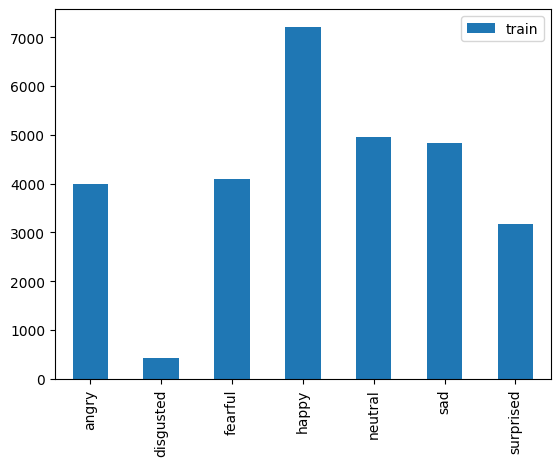

In [5]:
train_count.transpose().plot(kind='bar')

<Axes: >

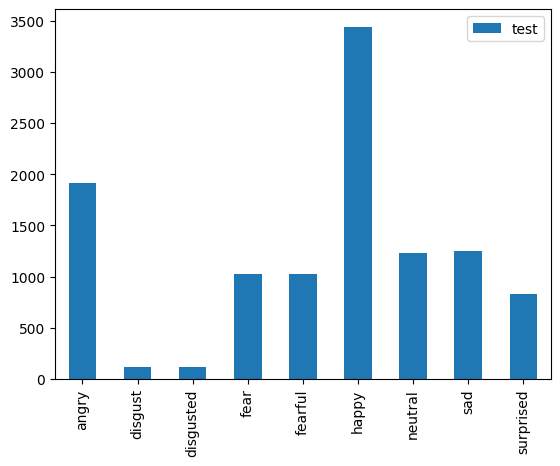

In [6]:
test_count.transpose().plot(kind='bar')

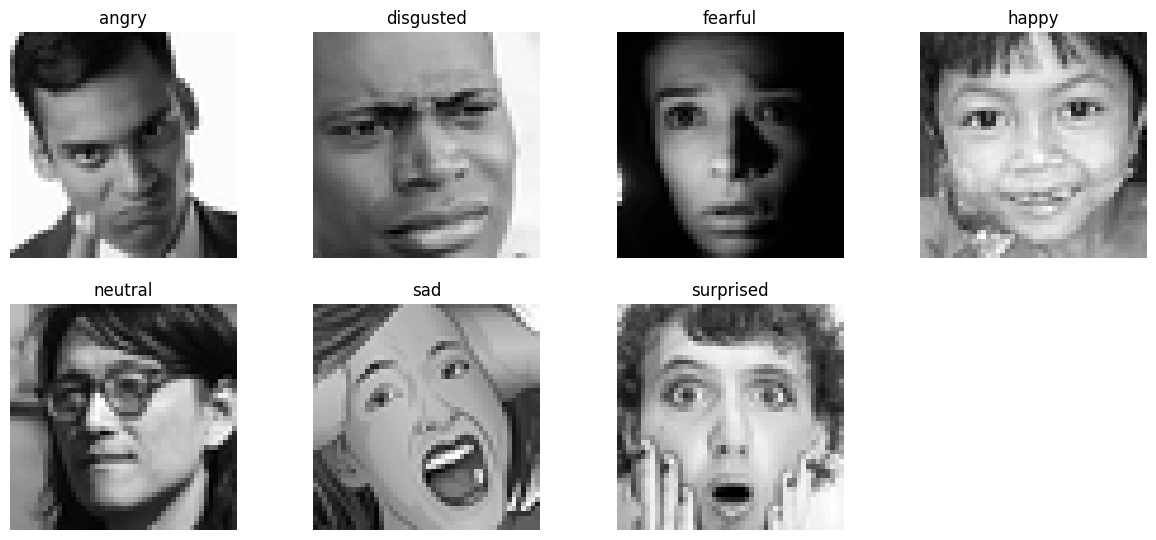

In [7]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [8]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

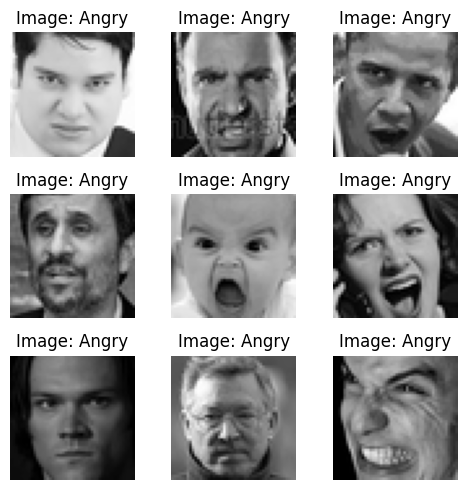

In [9]:
# Placeholder for the directory path
angry_directory_path = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

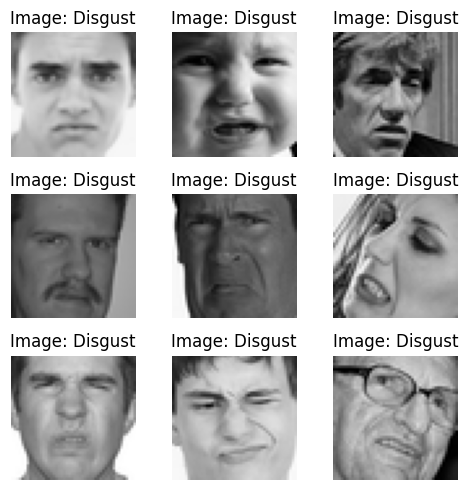

In [10]:
# Placeholder for the directory path
disgust_directory_path = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train/disgusted'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

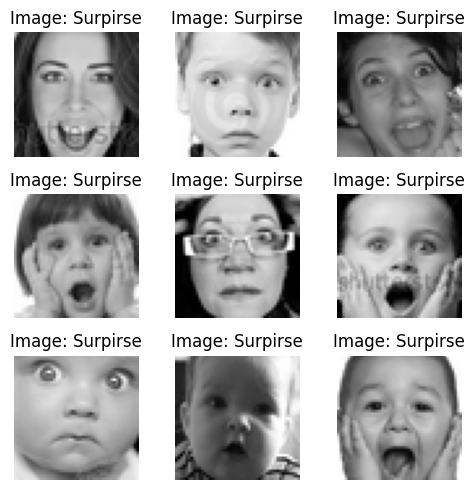

In [11]:
# Placeholder for the directory path
surpirse_directory_path = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train/surprised'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

In [12]:
image = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train/angry/im16.png'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [13]:
import cv2

image_path = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train/angry/im16.png'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


In [14]:
train_data_dir = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/train'
test_data_dir = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/Emo_data/test'

In [15]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

In [16]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 10939 images belonging to 9 classes.


In [17]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class labels: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'disgusted': 2, 'fear': 3, 'fearful': 4, 'happy': 5, 'neutral': 6, 'sad': 7, 'surprised': 8}


In [18]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/home/shubham/anaconda3/envs/emo/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732079015.929289   17654 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2609 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [20]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [22]:
# File path for the model checkpoint
cnn_path = '/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [23]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [24]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [25]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [26]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [27]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [28]:
train_generator.samples

22968

In [29]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10


/home/shubham/anaconda3/envs/emo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732079019.010227   17833 service.cc:148] XLA service 0x71b99c015db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732079019.010249   17833 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-20 10:33:39.110293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732079019.354537   17833 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-20 10:33:39.861065: I external/

  2/359 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.2031 - loss: 15.8680   

I0000 00:00:1732079029.363822   17833 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/359 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.2296 - loss: 13.8180

2024-11-20 10:34:07.308273: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[56,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[56,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 10:34:07.311533: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[56,64,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[56,32,48,48]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2449 - loss: 13.2953

2024-11-20 10:34:31.156424: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 10:34:31.159860: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,48,48]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF


Epoch 1: val_loss improved from inf to 14.95877, saving model to /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 142ms/step - accuracy: 0.2450 - loss: 13.2928 - val_accuracy: 0.1730 - val_loss: 14.9588 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
  1/359 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.3125 - loss: 11.0852

2024-11-20 10:34:40.305468: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-20 10:34:40.305503: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-20 10:34:40.305528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
/home/shubham/anaconda3/envs/emo/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-20 10:34:40.310791: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3432 - loss: 10.6738
Epoch 3: val_loss improved from 14.95877 to 9.81981, saving model to /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.3433 - loss: 10.6724 - val_accuracy: 0.3790 - val_loss: 9.8198 - learning_rate: 1.0000e-04
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
  1/359 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.3438 - loss: 9.0333

2024-11-20 10:35:16.506034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:35:16.508994: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 10:35:16.509021: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:35:16.509034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4455936260556590597


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3829 - loss: 8.5830
Epoch 5: val_loss improved from 9.81981 to 7.35582, saving model to /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.3830 - loss: 8.5817 - val_accuracy: 0.3780 - val_loss: 7.3558 - learning_rate: 1.0000e-04
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/10
  1/359 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.3750 - loss: 7.3353

2024-11-20 10:35:52.764362: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:35:52.767181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:35:52.767208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4455936260556590597


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4246 - loss: 6.7736
Epoch 7: val_loss improved from 7.35582 to 5.77018, saving model to /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.4247 - loss: 6.7725 - val_accuracy: 0.4156 - val_loss: 5.7702 - learning_rate: 1.0000e-04
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/10
  1/359 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.3750 - loss: 5.6430

2024-11-20 10:36:29.046205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:36:29.048939: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 10:36:29.048965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:36:29.048980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4455936260556590597


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4541 - loss: 5.3057
Epoch 9: val_loss improved from 5.77018 to 4.50331, saving model to /mnt/A42AC5272AC4F778/Emotion _Detection_CNN/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.4541 - loss: 5.3049 - val_accuracy: 0.4783 - val_loss: 4.5033 - learning_rate: 1.0000e-04
Epoch 10/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.


2024-11-20 10:37:05.379963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:37:05.382730: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12746398409249897027
2024-11-20 10:37:05.382762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4455936260556590597
